In this notebook, we need to do the following:
- Define the number of check in stations and voting booths in each precinct. This should be easy, just finding a cutoff for small or big precincts.
- Identify precincts by populace of disenfranchised voters. Need to see if this will create several clusters, or just a binary split.

In [15]:
import pandas as pd
import geopandas as gpd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

In [16]:
data = pd.read_csv('2026_predictions.csv')
data.sample(6)

,total,race_percent_white,race_percent_black,race_percent_native,race_percent_asian,race_percent_pacific_islander,race_percent_hispanic,race_percent_other,income_percent_below_15K,income_percent_15K_35K,income_percent_35K_65K,income_percent_above_65K,male_percent,female_percent,disability_percent,male_disability_percent,female_disability_percent,district,year,is_midterm,lagged_turnout,lagged_percentage_turnout,ballots_cast
567,1245.910257,0.139895,0.815022,0.0006,0.000000e+00,0.000,0.004964,0.002134,0.214598,0.397712,0.155036,0.087032,0.635610,0.364390,0.314524,0.193643,0.120881,PITTSBURGH WARD 13 DIST 6,2026,1,164,53.95,112
298,5999.941083,0.886115,0.013522,0.0000,6.928234e-02,0.000,0.000057,0.016409,0.196742,0.077673,0.116384,0.491062,0.538633,0.461367,0.029059,0.010845,0.018214,MARSHALL DIST 4,2026,1,1035,85.47,891
691,3083.534380,0.293793,0.523425,0.0000,9.658246e-02,0.000,0.030836,0.000000,0.328201,0.224791,0.203916,0.166392,0.519168,0.480832,0.093597,0.019085,0.074511,PITTSBURGH WARD 3 DIST 1,2026,1,148,62.45,101
156,1555.440085,0.921962,0.041656,0.0000,9.061492e-07,0.000,0.003297,0.035866,0.153621,0.334575,0.173393,0.149503,0.489268,0.510732,0.206174,0.124756,0.081418,DRAVOSBURG DIST 1,2026,1,387,71.67,309
746,1468.956157,0.006307,0.972497,0.0000,9.378289e-03,0.000,0.000053,0.000303,0.220674,0.323166,0.317067,0.073067,0.463959,0.536041,0.182306,0.065067,0.117239,PITTSBURGH WARD 5 DIST 3,2026,1,98,73.68,84
1127,1480.000000,0.222341,0.710557,0.0000,0.000000e+00,0.001,0.092573,0.020546,0.423703,0.165827,0.169286,0.169470,0.431081,0.568919,0.286486,0.065541,0.220946,PITTSBURGH WARD 12 DIST 2,2026,1,153,50.50,99


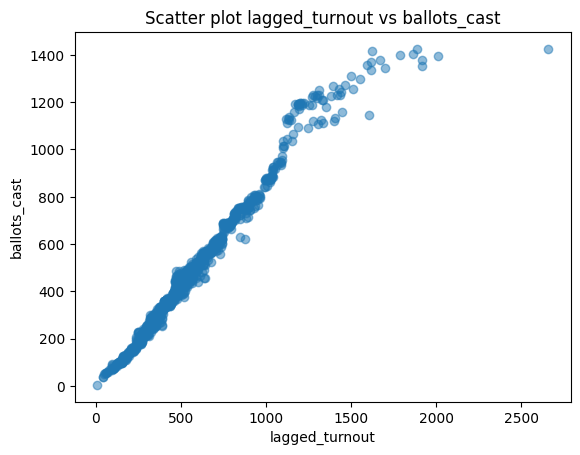

In [17]:
# Plot lagged_turnout vs ballots_cast

import matplotlib.pyplot as plt
plt.scatter(data.lagged_turnout, data.ballots_cast, alpha=0.5)
plt.title('Scatter plot lagged_turnout vs ballots_cast')
plt.xlabel('lagged_turnout')
plt.ylabel('ballots_cast')
plt.show()

Based on the trends, we can differentiate between precincts with 1200+ voters last year and those with less.

In [18]:
data['check_in_stations'] = 1
data['voting_booths'] = ((data['lagged_turnout'] > 1200).astype(int) + 1) * 3

In [19]:
data

,total,race_percent_white,race_percent_black,race_percent_native,race_percent_asian,race_percent_pacific_islander,race_percent_hispanic,race_percent_other,income_percent_below_15K,income_percent_15K_35K,income_percent_35K_65K,income_percent_above_65K,male_percent,female_percent,disability_percent,male_disability_percent,female_disability_percent,district,year,is_midterm,lagged_turnout,lagged_percentage_turnout,ballots_cast,check_in_stations,voting_booths
0,3587.021486,0.924896,0.003024,5.720420e-03,0.010605,0.000000e+00,0.028436,0.004876,0.146698,0.227556,0.174298,0.376845,0.472122,0.527878,0.209212,0.089035,0.120178,ALEPPO,2026,1,1128,82.76,1127,1,3
1,2819.197463,0.741135,0.065131,1.319492e-07,0.182826,0.000000e+00,0.004830,0.002541,0.056678,0.066834,0.254476,0.511867,0.417552,0.580313,0.100020,0.015977,0.084043,ASPINWALL DIST 1,2026,1,730,85.38,629,1,3
2,2830.095799,0.743008,0.065388,0.000000e+00,0.182487,0.000000e+00,0.004958,0.002505,0.057540,0.067789,0.254728,0.512205,0.419150,0.580850,0.100290,0.016164,0.084126,ASPINWALL DIST 2,2026,1,472,81.10,427,1,3
3,2831.447923,0.743035,0.065403,0.000000e+00,0.182351,0.000000e+00,0.004980,0.002494,0.057671,0.067945,0.254672,0.512033,0.419255,0.580708,0.100306,0.016192,0.084114,ASPINWALL DIST 3,2026,1,698,84.40,618,1,3
4,2203.983574,0.713338,0.229701,2.699011e-03,0.003748,0.000000e+00,0.026200,0.009296,0.178168,0.297448,0.284030,0.187192,0.605259,0.394741,0.234994,0.151556,0.083438,AVALON WARD 1,2026,1,849,76.14,707,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,1480.000000,0.222341,0.710557,0.000000e+00,0.000000,1.000000e-03,0.092573,0.020546,0.423703,0.165827,0.169286,0.169470,0.431081,0.568919,0.286486,0.065541,0.220946,PITTSBURGH WARD 12 DIST 2,2026,1,153,50.50,99,1,3
1128,1809.711974,0.093957,0.840640,0.000000e+00,0.000000,8.728051e-07,0.000000,0.099325,0.031905,0.607462,0.054432,0.299521,0.472320,0.527680,0.177457,0.000000,0.185119,PITTSBURGH WARD 12 DIST 9,2026,1,138,48.25,97,1,3
1129,3307.068654,0.374426,0.344919,4.739217e-03,0.021817,0.000000e+00,0.000000,0.000012,0.146051,0.083124,0.146735,0.552089,0.558772,0.441228,0.176877,0.132123,0.044753,PITTSBURGH WARD 21 DIST 3,2026,1,402,66.12,336,1,3
1130,3469.000000,0.685764,0.240840,2.710061e-02,0.000000,0.000000e+00,0.000799,0.029101,0.139538,0.159396,0.204255,0.364556,0.464975,0.535025,0.127703,0.084462,0.043240,PITTSBURGH WARD 22 DIST 2,2026,1,487,72.58,428,1,3


For n_clusters = 3 The average silhouette_score is : 0.37299170873740645
For n_clusters = 4 The average silhouette_score is : 0.22295064589444755
For n_clusters = 5 The average silhouette_score is : 0.23439509852917081
For n_clusters = 6 The average silhouette_score is : 0.17046282125313478
For n_clusters = 7 The average silhouette_score is : 0.16816288098671003
For n_clusters = 8 The average silhouette_score is : 0.16184638496267237
For n_clusters = 9 The average silhouette_score is : 0.1657837215024761
For n_clusters = 10 The average silhouette_score is : 0.1627486006038588
For n_clusters = 11 The average silhouette_score is : 0.1668805666560982
For n_clusters = 12 The average silhouette_score is : 0.15699017724109535
For n_clusters = 13 The average silhouette_score is : 0.15451858915724206
For n_clusters = 14 The average silhouette_score is : 0.1510191734717253


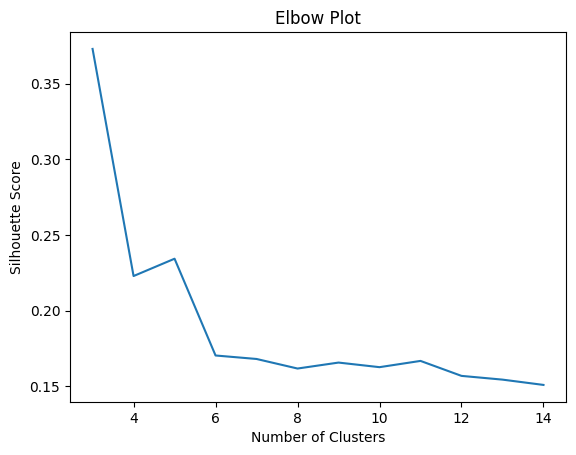

In [20]:
demo_data = data[['race_percent_white', 'race_percent_black',
       'race_percent_native', 'race_percent_asian',
       'race_percent_pacific_islander', 'race_percent_hispanic',
       'race_percent_other', 'income_percent_below_15K',
       'income_percent_15K_35K', 'income_percent_35K_65K',
       'income_percent_above_65K', 'male_percent', 'female_percent',
       'disability_percent', 'male_disability_percent',
       'female_disability_percent']]


# Elbow Plot
range_n_clusters = range(3, 15)
scores = []
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(demo_data)
    silhouette_avg = silhouette_score(demo_data, cluster_labels)
    scores.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
plt.plot(range_n_clusters, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Elbow Plot')
plt.show()


In [21]:
best_cluster = 6

clusterer = KMeans(n_clusters=best_cluster, random_state=10)
cluster_labels = clusterer.fit_predict(demo_data)

data['cluster'] = cluster_labels

In [22]:
for i in range(best_cluster):
    print('Cluster', i, 'has:', len(data[data['cluster'] == i]), 'precincts')


Cluster 0 has: 325 precincts
Cluster 1 has: 90 precincts
Cluster 2 has: 145 precincts
Cluster 3 has: 231 precincts
Cluster 4 has: 167 precincts
Cluster 5 has: 174 precincts


Notes:
- Cluster 0 is extremely white, with most income above 35K, and 12% disability rates. (Bethel Park, Ross, Shaler, Pittsburgh Ward 10)
- Cluster 1 is majority black, with most income below 35K, and 25% disability rates. (Homestead, McKeesport, Pittsburgh Ward 5)
- Cluster 2 is majority white, but income is evenly spread out, with 13% disability rates. (Coraopolis, Monroeville, Pitt Wards 4, 7, and 23)
- Cluster 3 is extremely white, with most of the population below 65K, and 18% disability rates. (Brentwood, West Mifflin)
- Cluster 4 is half white and half black, with most income below 65K, and 16% disability rates. (Clairton, Duquesne)
- Cluster 5 is extremely white, with almost half of income above 65K, and 9% disability rates. (Bethel Park, Fox Chapel)


In [23]:
precinct_data = gpd.read_file('relevant_precincts.geojson').to_crs('EPSG:3395')

In [24]:
precinct_data = precinct_data.merge(data, left_on='district', right_on='district')

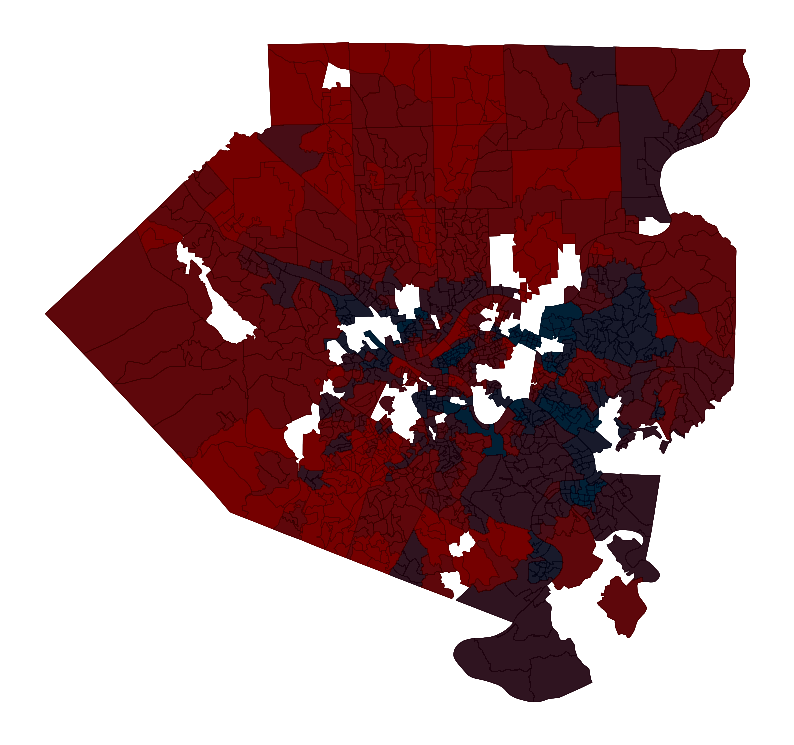

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


color_start = '#012136'
color_end = '#750000'

cmap = LinearSegmentedColormap.from_list('custom', [color_start, color_end], N=256)
order = [1, 4, 3, 2, 0, 5]
precinct_data['cluster'] = pd.Categorical(precinct_data['cluster'], categories=order, ordered=True)

precinct_data_sorted = precinct_data.sort_values('cluster')

fig, ax = plt.subplots(1, 1, figsize=(10, 10), facecolor='none')
ax.set_facecolor('none')  

precinct_data_sorted.plot(column='cluster', ax=ax, cmap=cmap, legend=False)
precinct_data_sorted.boundary.plot(ax=ax, linewidth=0.1, edgecolor='black', alpha=0.1)

plt.axis('off')
plt.show()

In [62]:
# hours = ['7 AM', '8 AM', '9 AM', '10 AM', '11 AM', '12 PM', '1 PM',
#          '2 PM', '3 PM', '4 PM', '5 PM', '6 PM', '7 PM']

import datetime
import numpy as np

start = "07:00:00"
end = "19:00:00"
delta = datetime.timedelta(minutes=5)
start = datetime.datetime.strptime( start, '%H:%M:%S' )
end = datetime.datetime.strptime( end, '%H:%M:%S' )

# Let's do every 5 minutes
time_slots = [ datetime.datetime.strftime(start + i*delta, '%H:%M') for i in range(int(((end-start).seconds/60)/5)) ]
num_intervals = len(time_slots)
time_numeric = np.arange(0, num_intervals)

morning_peak = 5
morning_peak_std = 3
morning_peak_height = 1

afternoon_peak = 72
afternoon_peak_std = 20
afternoon_peak_height = 0.4

evening_peak = 138
evening_peak_std = 7
evening_peak_height = 0.8

def generate_peak(x, mean, std):
    return np.exp(-0.5 * ((x - mean) / std) ** 2)

morning_peak = generate_peak(time_numeric, morning_peak, morning_peak_std) * morning_peak_height
afternoon_peak = generate_peak(time_numeric, afternoon_peak, afternoon_peak_std) * afternoon_peak_height
evening_peak = generate_peak(time_numeric, evening_peak, evening_peak_std) * evening_peak_height

combined_dist = morning_peak + afternoon_peak + evening_peak
weights = combined_dist / combined_dist.sum()

def randomize_ballots(row, weight):
    return int(np.random.randint((row['ballots_cast'] * 0.8), (row['ballots_cast'] * 1.2)) * weight) 
 
for i, time in enumerate(time_slots):
    data[time] = data.apply(lambda x: randomize_ballots(x, weights[i]), axis=1)


/var/folders/73/yf0vhxc16_s7l4d4j28m32bh0000gn/T/ipykernel_52604/3895546407.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[time] = data.apply(lambda x: randomize_ballots(x, weights[i]), axis=1)
/var/folders/73/yf0vhxc16_s7l4d4j28m32bh0000gn/T/ipykernel_52604/3895546407.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[time] = data.apply(lambda x: randomize_ballots(x, weights[i]), axis=1)
/var/folders/73/yf0vhxc16_s7l4d4j28m32bh0000gn/T/ipykernel_52604/3895546407.py:44: PerformanceWarning: DataFrame is highly f

In [63]:
data

,total,race_percent_white,race_percent_black,race_percent_native,race_percent_asian,race_percent_pacific_islander,race_percent_hispanic,race_percent_other,income_percent_below_15K,income_percent_15K_35K,income_percent_35K_65K,income_percent_above_65K,male_percent,female_percent,disability_percent,male_disability_percent,female_disability_percent,district,year,is_midterm,lagged_turnout,lagged_percentage_turnout,ballots_cast,check_in_stations,voting_booths,cluster,07:00,07:05,07:10,07:15,07:20,07:25,07:30,07:35,07:40,07:45,07:50,07:55,08:00,08:05,08:10,08:15,08:20,08:25,08:30,08:35,08:40,08:45,08:50,08:55,09:00,09:05,09:10,09:15,09:20,09:25,09:30,09:35,09:40,09:45,09:50,09:55,10:00,10:05,10:10,10:15,10:20,10:25,10:30,10:35,10:40,10:45,10:50,10:55,11:00,11:05,11:10,11:15,11:20,11:25,11:30,11:35,11:40,11:45,11:50,11:55,12:00,12:05,12:10,12:15,12:20,12:25,12:30,12:35,12:40,12:45,12:50,12:55,13:00,13:05,13:10,13:15,13:20,13:25,13:30,13:35,13:40,13:45,13:50,13:55,14:00,14:05,14:10,14:15,14:20,14:25,14:30,14:35,14:40,14:45,14:50,14:55,15:00,15:05,15:10,15:15,15:20,15:25,15:30,15:35,15:40,15:45,15:50,15:55,16:00,16:05,16:10,16:15,16:20,16:25,16:30,16:35,16:40,16:45,16:50,16:55,17:00,17:05,17:10,17:15,17:20,17:25,17:30,17:35,17:40,17:45,17:50,17:55,18:00,18:05,18:10,18:15,18:20,18:25,18:30,18:35,18:40,18:45,18:50,18:55
0,3587.021486,0.924896,0.003024,5.720420e-03,0.010605,0.000000e+00,0.028436,0.004876,0.146698,0.227556,0.174298,0.376845,0.472122,0.527878,0.209212,0.089035,0.120178,ALEPPO,2026,1,1128,82.76,1127,1,3,0,7,12,18,26,29,34,29,20,18,13,7,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,2,2,3,3,3,3,3,3,5,4,4,5,6,6,7,8,8,7,8,6,7,8,9,9,10,9,11,10,9,11,13,12,13,12,12,13,10,11,12,10,9,10,11,12,9,11,9,11,10,9,7,7,9,9,6,6,7,7,7,6,5,4,5,5,4,3,3,3,3,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,2,3,3,6,7,7,11,14,12,14,19,16,22,22,24,22,23,18,18,22,16
1,2819.197463,0.741135,0.065131,1.319492e-07,0.182826,0.000000e+00,0.004830,0.002541,0.056678,0.066834,0.254476,0.511867,0.417552,0.580313,0.100020,0.015977,0.084043,ASPINWALL DIST 1,2026,1,730,85.38,629,1,3,5,4,6,9,12,18,14,14,14,11,7,3,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,2,2,2,3,3,2,2,3,4,3,4,3,4,3,4,3,4,5,6,4,4,4,5,5,5,6,6,7,5,7,7,5,5,7,6,5,5,6,6,5,5,5,5,5,4,5,4,3,4,4,3,3,4,2,3,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1,1,2,3,3,4,5,6,7,7,11,12,11,14,10,14,10,12,10,10,8
2,2830.095799,0.743008,0.065388,0.000000e+00,0.182487,0.000000e+00,0.004958,0.002505,0.057540,0.067789,0.254728,0.512205,0.419150,0.580850,0.100290,0.016164,0.084126,ASPINWALL DIST 2,2026,1,472,81.10,427,1,3,5,3,5,6,8,8,10,10,8,7,4,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,1,2,2,2,2,2,2,3,2,3,3,4,4,4,3,4,3,4,4,4,3,3,3,4,4,4,4,3,4,3,4,4,4,3,4,4,4,4,3,4,3,3,2,3,3,2,2,2,2,2,2,1,2,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,2,3,4,4,5,5,5,6,7,9,10,10,8,9,9,6,6
3,2831.447923,0.743035,0.065403,0.000000e+00,0.182351,0.000000e+00,0.004980,0.002494,0.057671,0.067945,0.254672,0.512033,0.419255,0.580708,0.100306,0.016192,0.084114,ASPINWALL DIST 3,2026,1,698,84.40,618,1,3,5,3,7,11,14,14,18,18,11,9,5,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,2,2,2,2,3,3,3,2,3,3,4,3,4,4,3,4,5,6,4,5,4,5,6,5,6,6,6,6,6,6,6,5,7,6,6,5,6,6,4,5,6,6,5,6,5,4,4,4,4,4,3,4,2,3,2,3,3,2,2,1,2,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1,2,3,3,4,6,6,9,8,10,9,12,11,13,12,14,13,11,10,10
4,2203.983574,0.713338,0.229701,2.699011e-03,0.003748,0.000000e+00,0.026200,0.009296,0.178168,0.297448,0.284030,0.187192,0.605259,0.394741,0.234994,0.151556,0.083438,AVALON WARD 1,2026,1,849,76.14,707,1,3,2,3,7,10,17,18,20,17,13,8,7,3,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,2,2,2,2,2,3,3,4,3,3,3,4,3,4,6,6,4,5,6,6,6,7,6,6,6,7,7,7,7,7,7,7,6,7,7,6,6,6,6,6,6,6,5,6,4,6,5,4,5,4,5,4,4,4,4,3,3,3,2,2,2,2,1,2,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,2,2,2,3,4,4,6,8,9,10,10,11,11,11,13,12,13,13,13,11,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

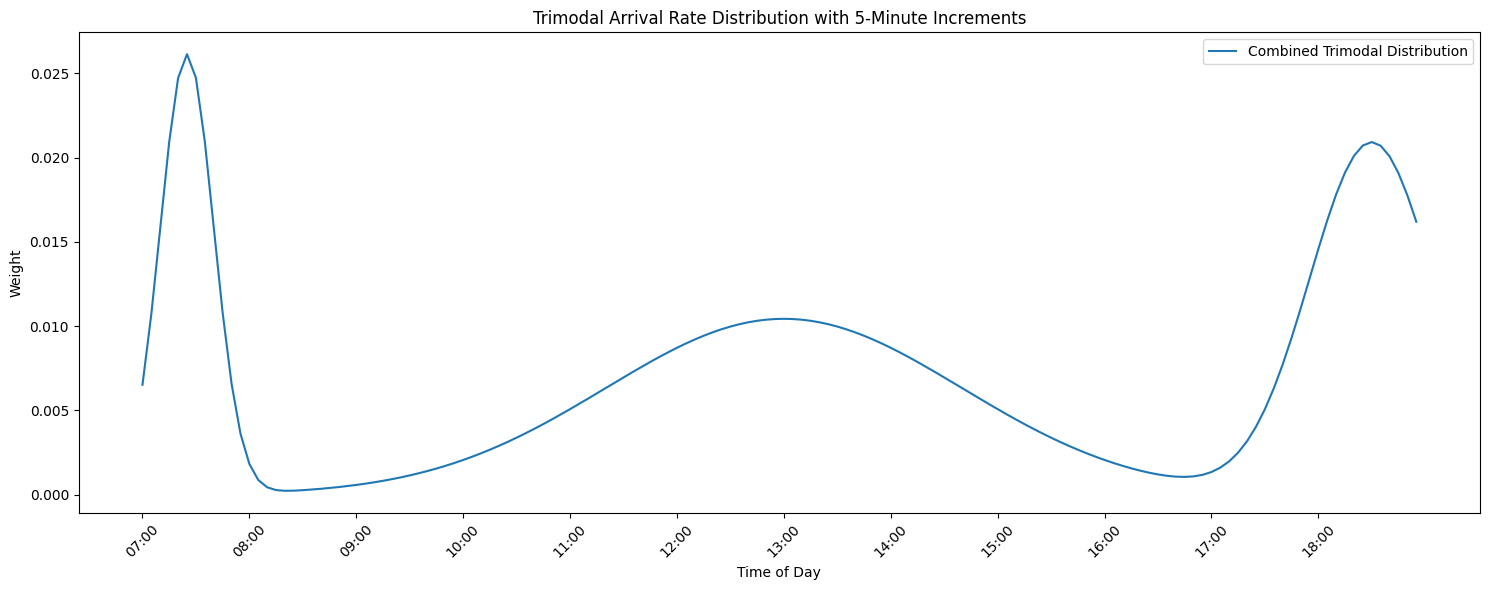

In [61]:
weights_df = pd.DataFrame({
    'time': time_slots,
    'weight': weights
})
plt.figure(figsize=(15, 6))
plt.plot(weights_df['time'], weights_df['weight'], label='Combined Trimodal Distribution')
plt.xlabel('Time of Day')
plt.ylabel('Weight')
plt.title('Trimodal Arrival Rate Distribution with 5-Minute Increments')
plt.xticks(ticks=np.arange(0, num_intervals, 12), labels=time_slots[::12], rotation=45)  # Show label every hour
plt.legend()
plt.tight_layout()
plt.show()



In [64]:
data.to_csv('2026_full_data.csv', index=False)